In [137]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score



# Prueba con modelo K-Means

In [138]:
# Carga de datos
df = pd.read_csv('../data_sample/gym_members_exercise_tracking.csv')
df.head()

,Age,Gender,Weight (kg),Height (m),Max_BPM,Avg_BPM,Resting_BPM,Session_Duration (hours),Calories_Burned,Workout_Type,Fat_Percentage,Water_Intake (liters),Workout_Frequency (days/week),Experience_Level,BMI
0,56,Male,88.3,1.71,180,157,60,1.69,1313.0,Yoga,12.6,3.5,4,3,30.20
1,46,Female,74.9,1.53,179,151,66,1.30,883.0,HIIT,33.9,2.1,4,2,32.00
2,32,Female,68.1,1.66,167,122,54,1.11,677.0,Cardio,33.4,2.3,4,2,24.71
3,25,Male,53.2,1.70,190,164,56,0.59,532.0,Strength,28.8,2.1,3,1,18.41
4,38,Male,46.1,1.79,188,158,68,0.64,556.0,Strength,29.2,2.8,3,1,14.39


In [139]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 973 entries, 0 to 972
Data columns (total 15 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   Age                            973 non-null    int64  
 1   Gender                         973 non-null    object 
 2   Weight (kg)                    973 non-null    float64
 3   Height (m)                     973 non-null    float64
 4   Max_BPM                        973 non-null    int64  
 5   Avg_BPM                        973 non-null    int64  
 6   Resting_BPM                    973 non-null    int64  
 7   Session_Duration (hours)       973 non-null    float64
 8   Calories_Burned                973 non-null    float64
 9   Workout_Type                   973 non-null    object 
 10  Fat_Percentage                 973 non-null    float64
 11  Water_Intake (liters)          973 non-null    float64
 12  Workout_Frequency (days/week)  973 non-null    int

In [140]:
df.describe()

,Age,Weight (kg),Height (m),Max_BPM,Avg_BPM,Resting_BPM,Session_Duration (hours),Calories_Burned,Fat_Percentage,Water_Intake (liters),Workout_Frequency (days/week),Experience_Level,BMI
count,973.000000,973.000000,973.00000,973.000000,973.000000,973.000000,973.000000,973.000000,973.000000,973.000000,973.000000,973.000000,973.000000
mean,38.683453,73.854676,1.72258,179.883864,143.766701,62.223022,1.256423,905.422405,24.976773,2.626619,3.321686,1.809866,24.912127
std,12.180928,21.207500,0.12772,11.525686,14.345101,7.327060,0.343033,272.641516,6.259419,0.600172,0.913047,0.739693,6.660879
min,18.000000,40.000000,1.50000,160.000000,120.000000,50.000000,0.500000,303.000000,10.000000,1.500000,2.000000,1.000000,12.320000
25%,28.000000,58.100000,1.62000,170.000000,131.000000,56.000000,1.040000,720.000000,21.300000,2.200000,3.000000,1.000000,20.110000
50%,40.000000,70.000000,1.71000,180.000000,143.000000,62.000000,1.260000,893.000000,26.200000,2.600000,3.000000,2.000000,24.160000
75%,49.000000,86.000000,1.80000,190.000000,156.000000,68.000000,1.460000,1076.000000,29.300000,3.100000,4.000000,2.000000,28.560000
max,59.000000,129.900000,2.00000,199.000000,169.000000,74.000000,2.000000,1783.000000,35.000000,3.700000,5.000000,3.000000,49.840000


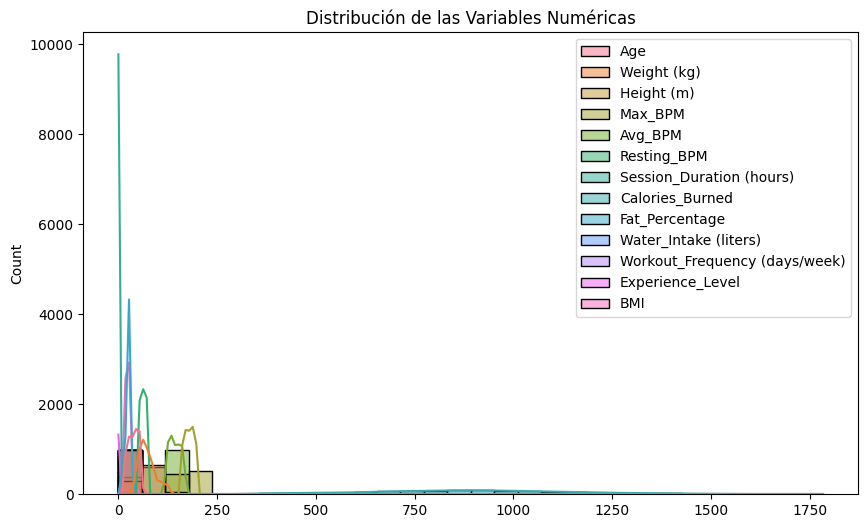

In [141]:
# Visualizaciones
plt.figure(figsize=(10, 6))
sns.histplot(df.select_dtypes(include=[np.number]), bins=30, kde=True)
plt.title('Distribución de las Variables Numéricas')
plt.show()


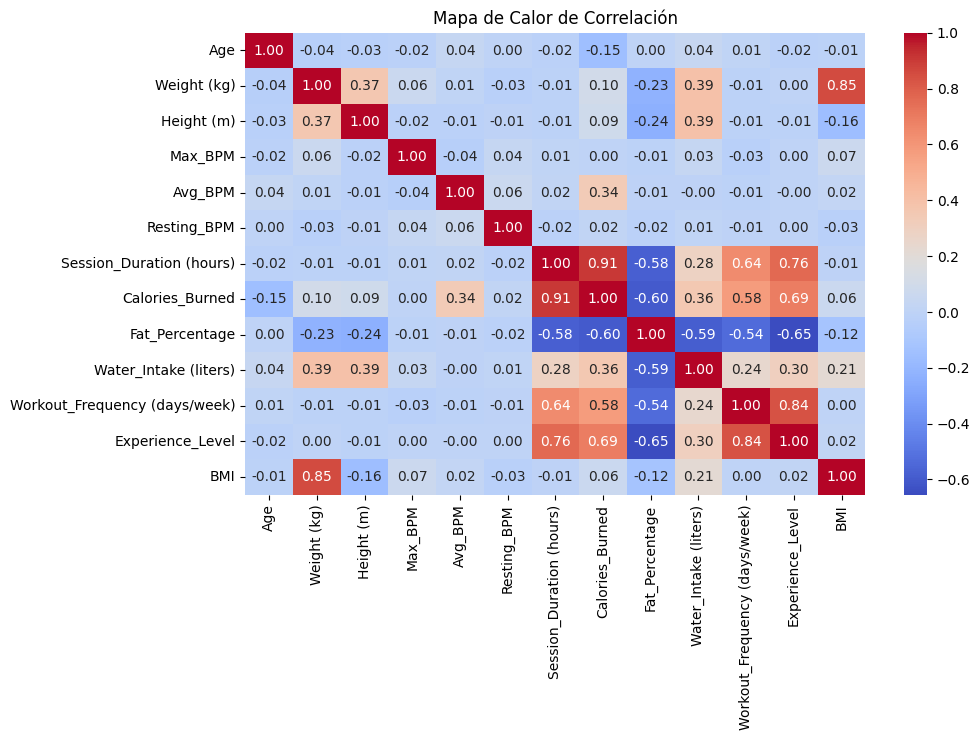

In [142]:
plt.figure(figsize=(10, 6))
sns.heatmap(df[numeric_cols].corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Mapa de Calor de Correlación')
plt.show()

In [143]:
# Preprocesamiento
# Identificar columnas categóricas
categorical_cols = df.select_dtypes(include=['object']).columns
numeric_cols = df.select_dtypes(include=[np.number]).columns

# Aplicar OneHot Encoding si hay columnas categóricas
if len(categorical_cols) > 0:
    encoder = OneHotEncoder(drop='first', sparse_output=False)
    encoded_cols = encoder.fit_transform(df[categorical_cols])
    encoded_df = pd.DataFrame(encoded_cols, columns=encoder.get_feature_names_out(categorical_cols))
    df = pd.concat([df[numeric_cols], encoded_df], axis=1)

# Escalado de datos
scaler = StandardScaler()
df[numeric_cols] = scaler.fit_transform(df[numeric_cols])


In [144]:
# Encontrar número óptimo de clusters
inertia = []
silhouette_scores = []
k_range = range(2, 11)

for k in k_range:
    kmeans = KMeans(n_clusters=k, init='k-means++', random_state=42)
    labels = kmeans.fit_predict(df)
    inertia.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(df, labels))


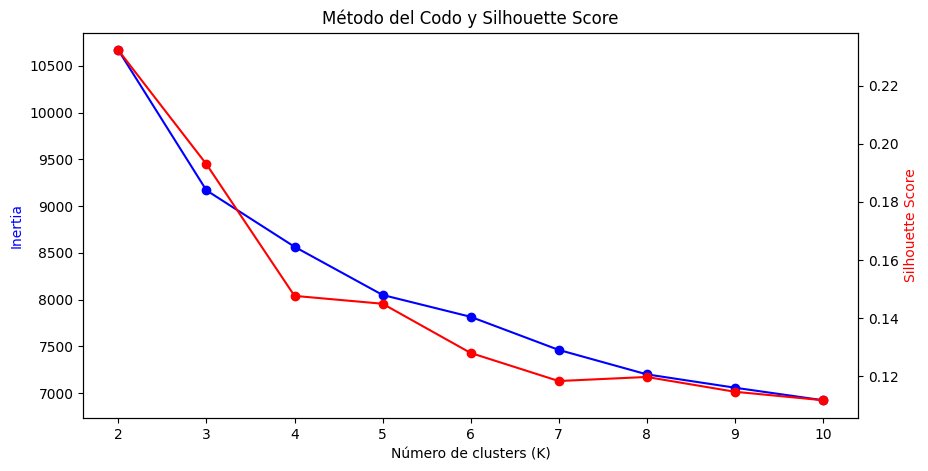

In [145]:
fig, ax1 = plt.subplots(figsize=(10,5))
ax1.plot(k_range, inertia, 'bo-', label='Inertia')
ax1.set_xlabel('Número de clusters (K)')
ax1.set_ylabel('Inertia', color='b')

ax2 = ax1.twinx()
ax2.plot(k_range, silhouette_scores, 'ro-', label='Silhouette Score')
ax2.set_ylabel('Silhouette Score', color='r')

plt.title('Método del Codo y Silhouette Score')
plt.show()

In [154]:
# Aplicar K-Means
n_clusters = 2  # Ajustar según el análisis
kmeans = KMeans(n_clusters=n_clusters, init='k-means++', random_state=42)
labels = kmeans.fit_predict(df)

In [155]:
# Evaluar clustering
silhouette = silhouette_score(df, labels)
davies_bouldin = davies_bouldin_score(df, labels)
calinski_harabasz = calinski_harabasz_score(df, labels)

print(f'Silhouette Score: {silhouette:.4f}')
print(f'Davies-Bouldin Score: {davies_bouldin:.4f}')
print(f'Calinski-Harabasz Score: {calinski_harabasz:.4f}')

Silhouette Score: 0.2322
Davies-Bouldin Score: 1.4832
Calinski-Harabasz Score: 251.8221


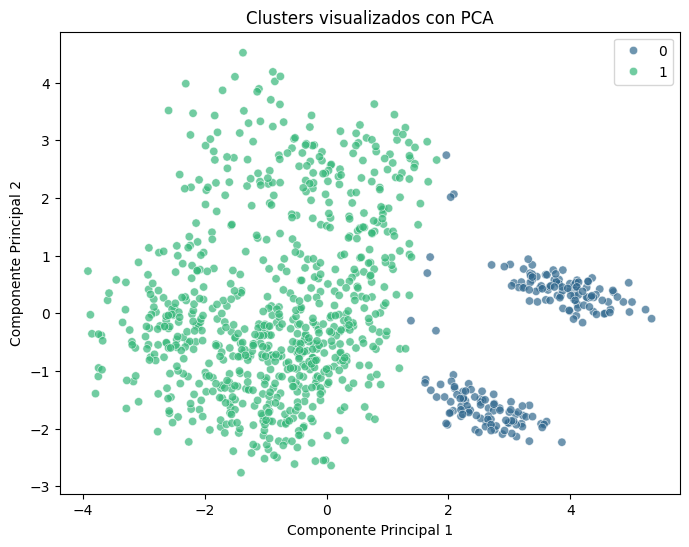

In [156]:
# Visualizar clusters con PCA
pca = PCA(n_components=2)
reduced_data = pca.fit_transform(df)

plt.figure(figsize=(8,6))
sns.scatterplot(x=reduced_data[:,0], y=reduced_data[:,1], hue=labels, palette='viridis', alpha=0.7)
plt.title('Clusters visualizados con PCA')
plt.xlabel('Componente Principal 1')
plt.ylabel('Componente Principal 2')
plt.show()